In [2]:
import os
import sys
import itertools
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

#pd.options.plotting.backend = "matplotlib"
rootPath = os.path.split(sys.path[0])[0]
sys.path.append(rootPath)
from src.features.calendar import easter_dates, easter_monday_dates

In [5]:
os.path.split(sys.path)

TypeError: expected str, bytes or os.PathLike object, not list

In [5]:
def load_data(rootPath, filename):
    data_df = pd.read_csv(os.path.join(rootPath, filename))
    data_df.sales_datetime = pd.to_datetime(data_df.sales_datetime, format='%Y-%m-%d', utc=True)
    data_df.set_index('sales_datetime', inplace=True)
    return data_df

def visualize_seasonality(item_daily_data_df):
    year_month_mean = item_daily_data_df.groupby(pd.Grouper(freq='MS')).agg({'sales_qty':'mean'})
    month_mean = item_daily_data_df.groupby(item_daily_data_df.index.month).agg({'sales_qty':'mean'})
    day_of_week_mean = item_daily_data_df.groupby(item_daily_data_df.index.day_of_week).agg({'sales_qty':'mean'})
    day_of_month_mean = item_daily_data_df.groupby(item_daily_data_df.index.day).agg({'sales_qty':'mean'})

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
    ax1.plot(year_month_mean)
    ax1.set_title("Overall trend (averaged monthly)")
    ax2.plot(month_mean)
    ax2.set_title("Monthly seasonality")
    ax3.plot(day_of_week_mean)
    ax3.set_title("Day of week average pattern")
    ax4.plot(day_of_month_mean)
    ax4.set_title("Day of month average pattern")

def fill_time_series(raw_data_df):
    # Dataframe must have DatetimeIndex format='%Y-%m-%d'
    data_df = raw_data_df.resample('D').sum()
    data_df.item_price = data_df.item_price.ffill().bfill()
    return data_df
    
    
def add_features_to_raw_data(raw_data_df):
    raw_data_df = raw_data_df.copy()
    raw_data_df.loc[:,'day_of_week'] = raw_data_df.index.day_of_week
    raw_data_df.loc[:,'month_of_year'] = raw_data_df.index.month
    day_of_week_dummies = pd.get_dummies(raw_data_df.day_of_week, prefix='day_of_week')
    month_of_year_dummies = pd.get_dummies(raw_data_df.month_of_year, prefix='month_of_year')
    raw_data_df = raw_data_df.merge(day_of_week_dummies, how='left', left_index=True, right_index=True)
    raw_data_df = raw_data_df.merge(month_of_year_dummies, how='left', left_index=True, right_index=True)
    raw_data_df.loc[:,'year'] = raw_data_df.index.year - raw_data_df.index.year.min()
    raw_data_df.loc[:,'first_third_of_month'] = (raw_data_df.index.day <= 10).astype('int8')
    raw_data_df.loc[:,'second_third_of_month'] = ((raw_data_df.index.day > 10) & (raw_data_df.index.day <= 20)).astype('int8')
    raw_data_df.loc[:,'last_third_of_month'] = (raw_data_df.index.day > 20).astype('int8')
    raw_data_df.drop(columns=['day_of_week', 'month_of_year'], inplace=True)
    return raw_data_df

def split_dataset(all_data_df: pd.DataFrame, 
                  validation_split_date: str, 
                  independent_vars: list, 
                  dependent_var: str):
    X_train = all_data_df[all_data_df.index < pd.to_datetime(validation_split_date, utc=True)][independent_vars].copy()
    X_test = all_data_df[all_data_df.index >= pd.to_datetime(validation_split_date, utc=True)][independent_vars].copy()
    y_train = all_data_df[all_data_df.index < pd.to_datetime(validation_split_date, utc=True)][dependent_var].copy()
    y_test = all_data_df[all_data_df.index >= pd.to_datetime(validation_split_date, utc=True)][dependent_var].copy()
    print(f"Train dataset is from {X_train.index.min().strftime('%Y-%m-%d')} to {X_train.index.max().strftime('%Y-%m-%d')}")
    print(f"Validation dataset is from {X_test.index.min().strftime('%Y-%m-%d')} to {X_test.index.max().strftime('%Y-%m-%d')}")
    return X_train, X_test, y_train, y_test

def wmape(actual: pd.Series, predicted: pd.Series):
    score = (np.abs(actual - predicted).sum() / np.abs(actual).sum())*100
    return round(score, 2)

def smape(A, F):
    score = 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    return round(score, 2)

def plot_fit_and_residuals(train_sales, 
                           train_predictions, 
                           val_sales, 
                           val_predictions, 
                           features_coefs_df,
                           train_residuals, 
                           test_residuals):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(30,20))

    train_sales.plot(kind='line', ax=ax1)
    train_predictions.plot(kind='line', ax=ax1)
    
    val_sales.plot(kind='line', ax=ax2)
    val_predictions.plot(kind='line', ax=ax2)
    
    ax3.scatter(train_residuals, train_predictions)
    ax4.scatter(test_residuals, val_predictions)
    
    features_coefs_df.plot(kind='barh', ax=ax5)
    plt.show()
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_sales.index, y=train_sales,
                        mode='lines',
                        name='Sales'))
    fig.add_trace(go.Scatter(x=train_predictions.index, y=train_predictions,
                        mode='lines',
                        name='Predictions'))
    fig.show()
    
def time_series_cv(raw_data_filled_df, num_train_years):
    
    groups = raw_data_filled_df.reset_index().groupby(raw_data_filled_df.index.year).groups
    sorted_groups = [value.tolist() for (key, value) in sorted(groups.items())]#list of indices per year
    if len(groups.keys()) < 2:
        raise ValueError("Not enough groups for validation set.")
    elif len(groups.keys()) <= num_train_years+1:
        return [(list(itertools.chain(*sorted_groups[:-1])), sorted_groups[-1])]
    else:
        return [(list(itertools.chain(*sorted_groups[i:num_train_years+i])), sorted_groups[i+num_train_years])
          for i in range(len(sorted_groups) - num_train_years)]

def transform_and_fit(
    raw_data_df: pd.DataFrame, 
    independent_vars: list, 
    dependent_var: str, 
    validation_split_date: str,
    visualize: bool):
    """ 
    Fills missing time series data in between raw_data_df.index.min() and raw_data_df.index.max(),
    adds calendar features, splits training dataset into training and validation dataset,
    fits estimator on training data and predicts on validation data.
    
    Parameters
    -----------
    raw_data_df: Time series dataframe
    independent_vars: list of column names to be used as independent variables for scikit-learn estimator
    dependent_var: column name to be used as dependent variable (target) for scikit-learn estimator
    validation_split_date: first date of validation set
    visualize: to plot or not
    
    Returns
    --------
    metrics_dict: metadata and metrics for individual item
    
    """
    item_name = raw_data_df.item_name.unique()[0]
    print(f"Transform and fit for {item_name}")
    data_filled = fill_time_series(raw_data_df.copy())
    data_w_feats = add_features_to_raw_data(data_filled)
    X_train, X_val, y_train, y_val = split_dataset(data_w_feats, validation_split_date, independent_vars, dependent_var)
    lin_reg = LinearRegression().fit(X_train, y_train)
    y_pred_train = lin_reg.predict(X_train)
    y_pred_train = pd.Series(y_pred_train, index=y_train.index)
    train_wmape = wmape(y_train, y_pred_train)
    #train_smape = smape(y_train, y_pred_train)
    print(f"Train WMAPE: {train_wmape}")
    #print(f"Train SMAPE: {train_smape}")
    y_pred_val = lin_reg.predict(X_val)
    y_pred_val = pd.Series(y_pred_val, index=y_val.index)
    val_wmape = wmape(y_val, y_pred_val)
    #val_smape = smape(y_val, y_pred_val)
    print(f"Validation WMAPE: {val_wmape}")
    #print(f"Validation SMAPE: {val_smape}")
    
    features_coefs = {var:lin_reg.coef_[idx] for idx,var in enumerate(independent_vars)}
    features_coefs_df = pd.Series(features_coefs)
    train_residuals = y_train - y_pred_train
    test_residuals = y_val - y_pred_val
    
    if visualize:
        plot_fit_and_residuals(y_train, 
                               y_pred_train, 
                               y_val, 
                               y_pred_val, 
                               features_coefs_df,
                               train_residuals, 
                               test_residuals)
    return {
        "item_name": item_name,
        "estimator": lin_reg.__class__.__name__,
        "train_from": X_train.index.min().strftime('%Y-%m-%d'),
        "train_to": X_train.index.max().strftime('%Y-%m-%d'),
        "val_from": X_val.index.min().strftime('%Y-%m-%d'),
        "val_to": X_val.index.max().strftime('%Y-%m-%d'),
        "train_wmape": train_wmape,
        #"train_smape": train_smape,
        "val_wmape": val_wmape,
        #"val_smape": val_smape,
        "features_coefs": features_coefs
    }
    
def transform_and_fit_gridsearch(
    raw_data_df: pd.DataFrame, 
    independent_vars: list, 
    dependent_var: str, 
    validation_split_date: str,
    visualize: bool):
    """ 
    Fills missing time series data in between raw_data_df.index.min() and raw_data_df.index.max(),
    adds calendar features, splits training dataset into training and validation dataset,
    fits estimator on training data and predicts on validation data.
    
    Parameters
    -----------
    raw_data_df: Time series dataframe
    independent_vars: list of column names to be used as independent variables for scikit-learn estimator
    dependent_var: column name to be used as dependent variable (target) for scikit-learn estimator
    validation_split_date: first date of validation set
    visualize: to plot or not
    
    Returns
    --------
    metrics_dict: metadata and metrics for individual item
    
    """
    item_name = raw_data_df.item_name.unique()[0]
    print(f"Executing transform and gridsearch fit for {item_name} ...")
    data_filled = fill_time_series(raw_data_df.copy())
    data_w_feats = add_features_to_raw_data(data_filled)
    X_train, X_val, y_train, y_val = split_dataset(data_w_feats, validation_split_date, independent_vars, dependent_var)
    cv_split_idxs = time_series_cv(X_train, num_train_years=3)
    wmape_scorer = make_scorer(wmape, greater_is_better=False)
    grid_search_params = {'alpha': [0.01, 0.1, 1.0, 10, 100]}
    lin_reg_gscv = GridSearchCV(
        Ridge(), 
        grid_search_params,
        scoring=wmape_scorer,
        cv=cv_split_idxs).fit(X_train, y_train)
    
    y_pred_train = lin_reg_gscv.predict(X_train)
    y_pred_train = pd.Series(y_pred_train, index=y_train.index)
    train_wmape = wmape(y_train, y_pred_train)
    #train_smape = smape(y_train, y_pred_train)
    print(f"Train WMAPE: {train_wmape}")
    #print(f"Train SMAPE: {train_smape}")
    y_pred_val = lin_reg_gscv.predict(X_val)
    y_pred_val = pd.Series(y_pred_val, index=y_val.index)
    val_wmape = wmape(y_val, y_pred_val)
    #val_smape = smape(y_val, y_pred_val)
    print(f"Validation WMAPE: {val_wmape}")
    #print(f"Validation SMAPE: {val_smape}")
    
    features_coefs = {var:lin_reg_gscv.best_estimator_.coef_[idx] for idx,var in enumerate(independent_vars)}
    features_coefs_df = pd.Series(features_coefs)
    train_residuals = y_train - y_pred_train
    test_residuals = y_val - y_pred_val
    
    if visualize:
        plot_fit_and_residuals(y_train, 
                               y_pred_train, 
                               y_val, 
                               y_pred_val, 
                               features_coefs_df,
                               train_residuals, 
                               test_residuals)
    return {
        "item_name": item_name,
        "estimator": lin_reg_gscv.best_estimator_.__class__.__name__,
        "train_from": X_train.index.min().strftime('%Y-%m-%d'),
        "train_to": X_train.index.max().strftime('%Y-%m-%d'),
        "val_from": X_val.index.min().strftime('%Y-%m-%d'),
        "val_to": X_val.index.max().strftime('%Y-%m-%d'),
        "train_wmape": train_wmape,
        "val_wmape": val_wmape,
        "features_coefs": features_coefs
    }    

    
    
    
    
    
    

In [62]:
TRAIN_FILENAME = 'data/interim/train_data_90_perc_value_v1_3.csv'
train_data = load_data(rootPath, TRAIN_FILENAME)


In [64]:
train_data.describe()
#dependent.plot(kind='kde')

,item_price,sales_qty
count,50063.000000,50063.000000
mean,11.780873,0.032635
std,3.492571,0.050100
min,0.250000,0.000000
25%,9.000000,0.009569
50%,12.000000,0.014354
75%,15.000000,0.033493
max,25.000000,1.000000


In [ ]:
#train_data.groupby('item_name').agg({'item_name': 'count'}).rename(columns={'item_name':'num_days_sales'}).sort_values(by='num_days_sales', ascending=False)

In [65]:
INDEPENDENT_VARS = ['item_price','day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'month_of_year_1', 'month_of_year_2',
       'month_of_year_3', 'month_of_year_4', 'month_of_year_5',
       'month_of_year_6', 'month_of_year_7', 'month_of_year_8',
       'month_of_year_9', 'month_of_year_10', 'month_of_year_11',
       'month_of_year_12', 'year', 'first_third_of_month',
       'second_third_of_month', 'last_third_of_month']
DEPENDENT_VAR = 'sales_qty'
VALIDATION_SPLIT_DATE = '2018-01-01'

In [66]:
cols = ['estimator', 'train_from', 'train_to', 'val_from', 
        'val_to', 'train_wmape', 'train_smape', 'val_wmape', 
        'val_smape', 'features_coefs']
metrics_df = pd.DataFrame(columns=cols)
train_data.item_name.unique().tolist()

for item in train_data.item_name.unique().tolist():
    raw_data_df = train_data[train_data.item_name == item].copy()
    if raw_data_df.index.max() > pd.to_datetime(VALIDATION_SPLIT_DATE, utc=True):
        metrics_dict = transform_and_fit_gridsearch(raw_data_df, INDEPENDENT_VARS, DEPENDENT_VAR, VALIDATION_SPLIT_DATE, visualize=False)
        metrics_df = metrics_df.append(metrics_dict, ignore_index=True)

Executing transform and gridsearch fit for Beck`s ...
Train dataset is from 2016-06-14 to 2017-12-31
Validation dataset is from 2018-01-01 to 2018-12-31
Train WMAPE: 57.0
Validation WMAPE: 58.67
Executing transform and gridsearch fit for White_coffee ...
Train dataset is from 2013-01-28 to 2017-12-31
Validation dataset is from 2018-01-01 to 2018-12-31
Train WMAPE: 48.51
Validation WMAPE: 54.86
Executing transform and gridsearch fit for Budweiser ...
Train dataset is from 2014-01-09 to 2017-12-31
Validation dataset is from 2018-01-01 to 2018-12-31
Train WMAPE: 56.4
Validation WMAPE: 75.38
Executing transform and gridsearch fit for Tea ...
Train dataset is from 2013-01-28 to 2017-12-31
Validation dataset is from 2018-01-01 to 2018-12-31
Train WMAPE: 97.65
Validation WMAPE: 61.24
Executing transform and gridsearch fit for Cappuccino ...
Train dataset is from 2013-01-29 to 2017-12-31
Validation dataset is from 2018-01-01 to 2018-12-31
Train WMAPE: 51.91
Validation WMAPE: 43.18
Executing tr

In [67]:
#metrics_df.to_csv(os.path.join(rootPath,'reports/scores/score_v1.csv'), index=False)
# not scaled features wmape mean 54.717714 60.119143
# not scaled features wmape median 52.550000 59.980000
# scaled features wmape mean 56.105429 61.124000
# scaled features wmape median 53.390000 61.2400
metrics_df.describe()

,train_wmape,train_smape,val_wmape,val_smape
count,35.000000,0.0,35.000000,0.0
mean,54.717714,NaN,60.119143,NaN
std,15.111217,NaN,19.735531,NaN
min,22.780000,NaN,24.900000,NaN
25%,47.940000,NaN,49.920000,NaN
50%,52.550000,NaN,59.980000,NaN
75%,60.220000,NaN,71.275000,NaN
max,97.650000,NaN,121.430000,NaN


In [55]:
metrics_scaled_df = pd.read_csv(os.path.join(rootPath,'reports/scores/scaled_and_times_10_100.csv'))
print(metrics_scaled_df.describe())
print(metrics_df.describe())

       train_wmape  train_smape   val_wmape  val_smape
count    35.000000          0.0   35.000000        0.0
mean     54.708571          NaN   59.931429        NaN
std      15.084558          NaN   19.617268        NaN
min      23.270000          NaN   24.940000        NaN
25%      47.850000          NaN   49.940000        NaN
50%      52.580000          NaN   60.090000        NaN
75%      60.155000          NaN   70.895000        NaN
max      97.650000          NaN  120.110000        NaN
       train_wmape  train_smape   val_wmape  val_smape
count    35.000000          0.0   35.000000        0.0
mean     54.717714          NaN   60.119143        NaN
std      15.111217          NaN   19.735531        NaN
min      22.780000          NaN   24.900000        NaN
25%      47.940000          NaN   49.920000        NaN
50%      52.550000          NaN   59.980000        NaN
75%      60.220000          NaN   71.275000        NaN
max      97.650000          NaN  121.430000        NaN


In [48]:
#train_data['value'] = train_data['item_price']*train_data['sales_qty']
item = 'Large_coffee_with_milk'
item_data_df = train_data[train_data.item_name == item].copy()

Executing transform and gridsearch fit for Large_coffee_with_milk ...
Train dataset is from 2013-01-28 to 2017-12-31
Validation dataset is from 2018-01-01 to 2018-12-31
sales_datetime
2013-01-28 00:00:00+00:00    31.682210
2013-01-29 00:00:00+00:00    30.279548
2013-01-30 00:00:00+00:00    29.583705
2013-01-31 00:00:00+00:00    31.360464
2013-02-01 00:00:00+00:00    33.570678
                               ...    
2017-12-27 00:00:00+00:00    46.568883
2017-12-28 00:00:00+00:00    48.345642
2017-12-29 00:00:00+00:00    47.630753
2017-12-30 00:00:00+00:00    56.977271
2017-12-31 00:00:00+00:00    64.956599
Freq: D, Length: 1799, dtype: float64
Train WMAPE: 22.78
Validation WMAPE: 24.9


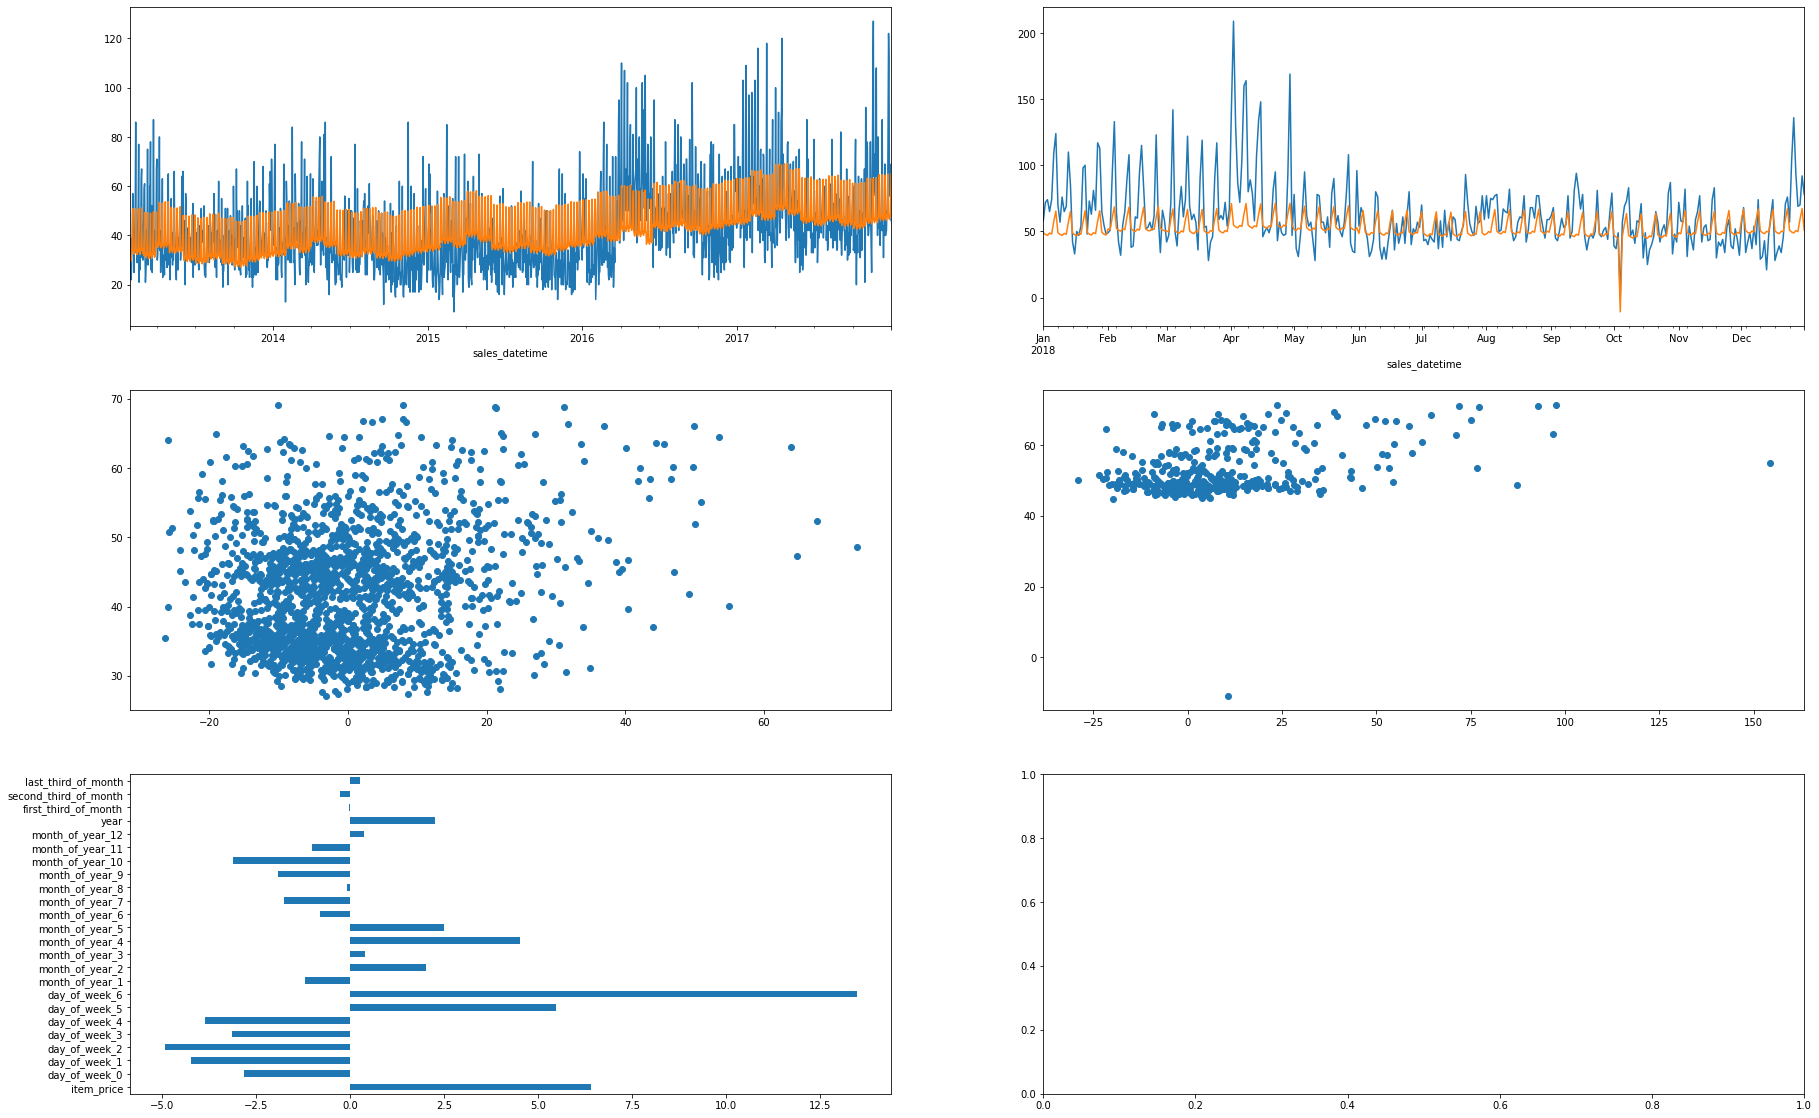

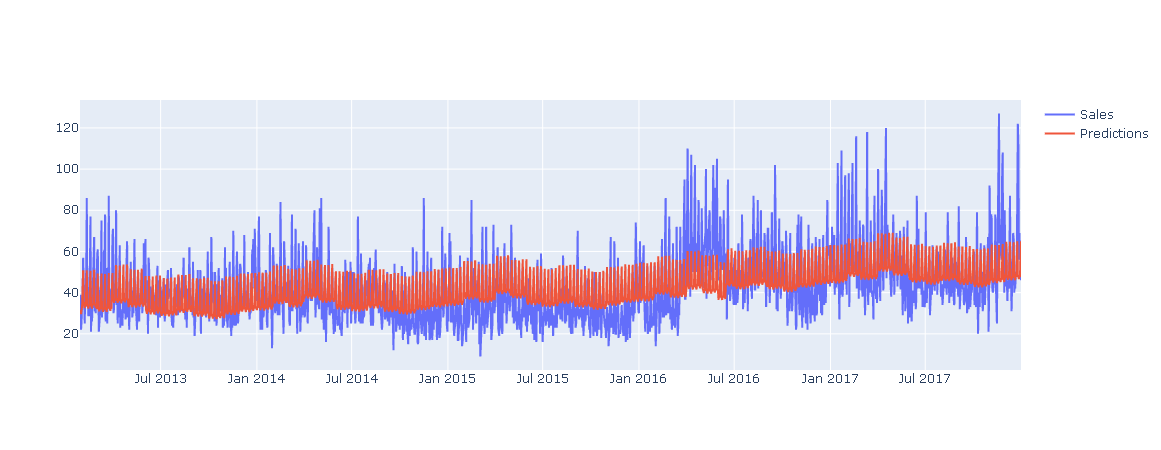

{'item_name': 'Large_coffee_with_milk',
 'estimator': 'Ridge',
 'train_from': '2013-01-28',
 'train_to': '2017-12-31',
 'val_from': '2018-01-01',
 'val_to': '2018-12-31',
 'train_wmape': 22.78,
 'val_wmape': 24.9,
 'features_coefs': {'item_price': 6.405318330912606,
  'day_of_week_0': -2.8199352859397355,
  'day_of_week_1': -4.222597229364484,
  'day_of_week_2': -4.918440001014551,
  'day_of_week_3': -3.1416814428510955,
  'day_of_week_4': -3.856569804975687,
  'day_of_week_5': 5.489948326903403,
  'day_of_week_6': 13.469275437242166,
  'month_of_year_1': -1.1830506924366466,
  'month_of_year_2': 2.0131125169846293,
  'month_of_year_3': 0.3965362264997361,
  'month_of_year_4': 4.530563185782153,
  'month_of_year_5': 2.5036964039202,
  'month_of_year_6': -0.7960121778439602,
  'month_of_year_7': -1.7531780982847078,
  'month_of_year_8': -0.08419138584517248,
  'month_of_year_9': -1.8970829602601376,
  'month_of_year_10': -3.0974006808657446,
  'month_of_year_11': -1.0008425045937863,
  

In [53]:
#Train WMAPE: 22.41
#Validation WMAPE: 25.71
transform_and_fit_gridsearch(item_data_df, INDEPENDENT_VARS, DEPENDENT_VAR, VALIDATION_SPLIT_DATE, visualize=True)